# 範例 : (Kaggle)房價預測
***
- 以下用房價預測資料, 觀察去除離群值的影響

# [教學目標]
- 以下用房價預測資料, 觀察去除離群值的影響

# [範例重點]
- 觀察原始數值的散佈圖, 以及線性迴歸分數 (In[5], Out[5]) 
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[7], Out[7])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = './../../../data/'
df_train = pd.read_csv(data_path + 'house_train.csv')

#数据平滑处理np.log1p，可以对偏度比较大的数据用log1p函数进行转化
#SalePric是資料的Label
train_Y = np.log1p(df_train['SalePrice'])
#train_Y.head()
df = df_train.drop(['Id', 'SalePrice'] , axis=1) #把Id和SalePrice欄位去除
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [3]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [4]:
# 找int64, float64的欄位
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [6]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1) # fillna 取代空值NaN為-1
MMEncoder = MinMaxScaler() #sklearn的MinMaxScaler為将属性缩放到一个指定的最大和最小值（通常是1-0）之间，这样处理差非常小的属性增强其稳定性，也可维持稀疏矩阵中为0的条目。
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [7]:
MMEncoder

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
#SalePrice 的全部數值
train_Y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

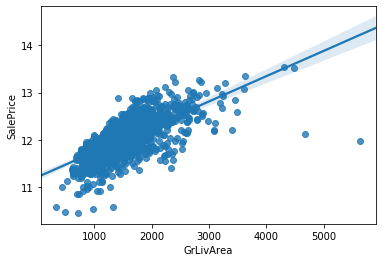

0.8499683837163878

In [9]:
# 情境一：正常數值
# 顯示 欄位GrLivArea 與 目標值SalePrice 的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = df['GrLivArea'], y=train_Y) #畫圖function
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df) # sklearn的fit_transform為 先拟合数据，再标准化
#train_X
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean() #cross_val_score交叉驗證，cv=5分5組的意思，
#0.8499  取平均數來看精準度

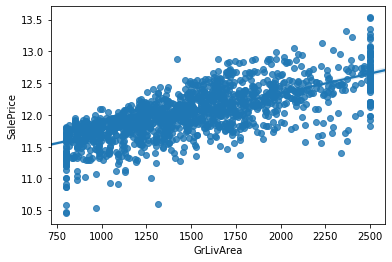

0.8590286613713278

In [10]:
# 情境二：將 GrLivArea 限制在 800 到 2500 以內, SalesPrice未改
# 將 GrLivArea 限制在 800 到 2500 以內, 調整離群值
df['GrLivArea'] = df['GrLivArea'].clip(800, 2500)
sns.regplot(x = df['GrLivArea'], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

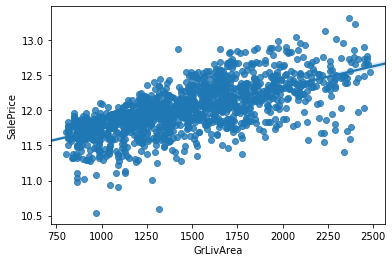

0.8765064877034943

In [11]:
#情境三： GrLivArea 限制在 800 到 2500 以內, SalesPrice也更改
# 將 GrLivArea 限制在 800 到 2500 以內, 捨棄離群值
keep_indexs = (df['GrLivArea']> 800) & (df['GrLivArea']< 2500)
df = df[keep_indexs]
train_Y = train_Y[keep_indexs]
sns.regplot(x = df['GrLivArea'], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。